In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
import random

In [3]:
#VARIABLE PARAMETERS (4/29)

# Define Functions

In [ ]:
def calc_s0(psi_init, h, m, g, mu, k, x_max, x_min, steps,x_vec,temp,potential):
    
    beta=1/k*temp

    #laplacian
    laps=[]
    for i in range(1,len(psi_init)-1):
        laplacian=-h**2/(2*m)*(psi_init[i+1]-2*psi_init[i]+psi_init[i-1])*psi_init[i]/((x_max-x_min)/steps)**2
        laps.append(laplacian.copy())
    laps_term=laps*np.conjugate(psi_init[1:-1])
    laps_int=integrate.simpson(laps_term, x=x_vec[1:-1])
    print("Laplacian Term: ", laps_int)

    #Potential term
    potential_term=potential*np.conjugate(psi_init)*psi_init
    potential_integrate=integrate.simpson(potential_term, x=x_vec)
    print("Potential Term: ", potential_integrate)

    #Norm^4
    norm4=(np.conjugate(psi_init)*psi_init)**2
    #print(norm4)
    norm4_term=integrate.simpson(norm4, x=x_vec)
    print("Norm^4 Term: ", norm4_term)

    #Norm^2 (part of number operation)
    norm2=np.conjugate(psi_init)*psi_init #I feel like this needs to explicitly be something times complex conj...
    norm2_term=integrate.simpson(norm2, x=x_vec)
    print("Norm^2 Term: ", norm2_term)

    S_0=-beta*((laps_int+potential_integrate+(g/2)*norm4_term)-mu*norm2_term)
    #print(S_0)

    return S_0

In [18]:
def check_func(s0_final, s0_init, psi_new,psi_old,x_max, x_min, steps):

    dx=(x_max-x_min)/steps
    a=np.exp(s0_final-s0_init)
    print("value of a is: ", a)

    if a>=1:
        pass
        print("Candidate state is more probable than seeding state. Candidate state accepted.")
        accepted_s=s0_final
        psi_out=psi_new
    if a<1:
        rand=random.random() #generate random number between 0,1
        print("rand value is: ",rand)
        if rand<=a:
        #if rand >=.5:
            psi_out=psi_new
            print("From random number generation, candidate state is accepted.")
            accepted_s=s0_final
        else:
            pass
            print("From random number generation, candidate state is rejected.")
            accepted_s=s0_init
            psi_out=psi_old

    #normalize psi_out
    psi_out_norm=psi_out/np.sqrt(np.sum(np.abs(psi_out)**2)*dx)
    
    return accepted_s, psi_out_norm

In [19]:
def loop_stochastic(h, m, g, k, mu, c1, c2, c3, v, phi, u, x_max, x_min, nsteps, xgrid, initial_wave_func, potential_func, iterations, temp):

    #Define initial and boundary conditions
    iter=0
    entropy_store=[]
    psi_store=[]
    psi_sq_store=[]
    psi_store.append(initial_wave_func.copy())

    while iter<iterations:

        print("Iteration: ", iter)

        #calculate inital entropy
        s0_init=calc_s0(initial_wave_func, h, m, g, mu, k, x_max, x_min, nsteps,xgrid, temp, potential_func)
        print("Initial reduced entropy: ",s0_init)

        # PERTURBATION
        rand=random.choice([0,1])

        if rand==0:
            #print("Generating density perturbation...")
            psi=initial_wave_func*(1+c1*v*np.sin(k*xgrid+phi))
        if rand==1:
            #print("Generating phase perturbation...")
            psi=initial_wave_func*np.exp((1j*c2*v*np.sin(k*xgrid+phi)))

        # Vary particle number
        psi=(1+c3*u)*psi
        #print("new psi is:",psi)

        # Calculate reduced energy of perturbed field
        s0_final=calc_s0(psi, h, m, g, mu, k, x_max, x_min, nsteps,xgrid, temp, potential_func)
        print("Final reduced entropy: ", s0_final)

        # Accept or reject perturbation
        accepted_s, initial_wave_func=check_func(s0_final, s0_init, psi, initial_wave_func, x_max, x_min, nsteps)
        entropy_store.append(accepted_s)
        psi_store.append(initial_wave_func)
        psi_sq=np.conjugate(initial_wave_func)*initial_wave_func
        psi_sq_store.append(psi_sq.copy())
        
        iter+=1
    return psi_store, psi_sq_store, entropy_store

# Run Code

In [26]:
#Define Constants
omega=1
hbar=1
mass=1
g_param=-1
k_boltz=1
mu_chem_potential=1
#N_iterations=10
c1_val=1
c2_val=1
c3_val=.001
v_val=1
phase=1
u=1

#Construct grid
x_start=-5
x_end=5
num_steps=100
grid=np.linspace(x_start,x_end, num_steps)

#Construct potential and initial wave function
psi_0=(1/np.pi**.25)*np.exp(-.5*grid**2)
V=grid**2/2

#Define run parameters
iterations=1000
temperature=10

In [27]:
psi_array, psi_sq_array, entropy_array=loop_stochastic(hbar, mass, g_param, k_boltz, mu_chem_potential, c1_val, c2_val, c3_val, v_val, phase, u, x_end, x_start, num_steps, grid, psi_0, V, iterations, temperature)
psi_array2, psi_sq_array2, entropy_array2=loop_stochastic(hbar, mass, g_param, k_boltz, mu_chem_potential, c1_val, c2_val, c3_val, v_val, phase, u, x_end, x_start, num_steps, grid, psi_0, V, iterations, 20)

Iteration:  0
Laplacian Term:  0.2082269543852865
Potential Term:  0.24999999997908753
Norm^4 Term:  0.3989422804014328
Norm^2 Term:  0.9999999999983733
Initial reduced entropy:  0.5769809460707802
Laplacian Term:  1.7768410959221366
Potential Term:  0.520737998088472
Norm^4 Term:  4.165507083698136
Norm^2 Term:  2.892999788770289
Final reduced entropy:  30.49556660805704
value of a is:  9850916987787.018
Candidate state is more probable than seeding state. Candidate state accepted.
Iteration:  1
Laplacian Term:  0.36658373812916983
Potential Term:  0.18181749611896866
Norm^4 Term:  0.5078093397735005
Norm^2 Term:  1.0101010101005794
Initial reduced entropy:  3.3766081088689344
Laplacian Term:  3.1267099378858667
Potential Term:  0.5429524963546859
Norm^4 Term:  6.344701498271778
Norm^2 Term:  3.323872613392344
Final reduced entropy:  54.237209293278354
value of a is:  1.2259660415286683e+22
Candidate state is more probable than seeding state. Candidate state accepted.
Iteration:  2
La

C:\Users\svene\AppData\Local\Temp\ipykernel_9824\3838939369.py:4: RuntimeWarning: overflow encountered in exp
  a=np.exp(s0_final-s0_init)


Potential Term:  0.16135900722947505
Norm^4 Term:  1.8956749922291434
Norm^2 Term:  1.0101078250489854
Initial reduced entropy:  101.63129546671004
Laplacian Term:  76.78552912587746
Potential Term:  0.6393930584839425
Norm^4 Term:  30.09383389411421
Norm^2 Term:  4.001011324204132
Final reduced entropy:  907.929518820302
value of a is:  inf
Candidate state is more probable than seeding state. Candidate state accepted.
Iteration:  85
Laplacian Term:  9.740420773230479
Potential Term:  0.16142351816136974
Norm^4 Term:  1.9181179169393212
Norm^2 Term:  1.0101100028953969
Initial reduced entropy:  104.37045213249229
Laplacian Term:  (5.113631771864878+8.334255866373645j)
Potential Term:  (0.16174652662121058+2.0118106923906314e-18j)
Norm^4 Term:  (1.9258019049889687-5.054289451973711e-17j)
Norm^2 Term:  (1.0121312330111905-1.146571167362515e-17j)
Final reduced entropy:  (58.13573074437033+83.34255866373645j)
value of a is:  (-7.513958400137385e-22+8.293550258333568e-21j)
rand value is:  0

# Plotting

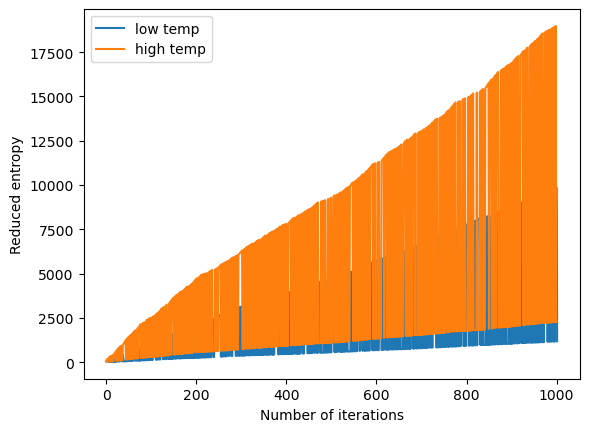

In [43]:
#Plot Reduced Entropy
fig=plt.figure()
plt.plot(np.linspace(0,iterations+1,iterations), np.real(entropy_array), label="low temp")
plt.plot(np.linspace(0,iterations+1,iterations), np.real(entropy_array2), label="high temp")
plt.xlabel("Number of iterations")
plt.ylabel("Reduced entropy")
plt.legend()
#plt.xlim(0,20)
plt.show()

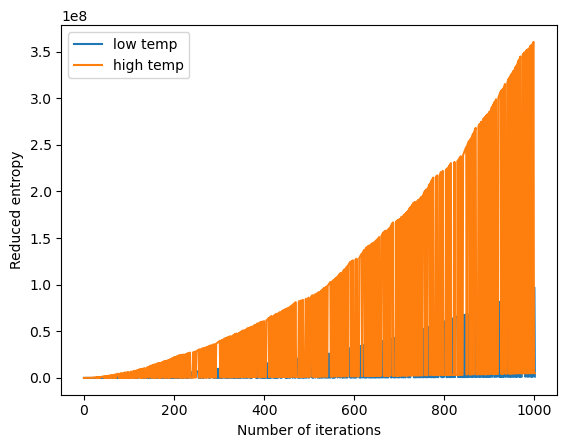

In [45]:
#Plot Reduced Entropy
fig=plt.figure()
plt.plot(np.linspace(0,iterations+1,iterations), np.abs(entropy_array)**2, label="low temp")
plt.plot(np.linspace(0,iterations+1,iterations), np.abs(entropy_array2)**2, label="high temp")
plt.xlabel("Number of iterations")
plt.ylabel("Reduced entropy")
plt.legend()
#plt.xlim(0,20)
plt.show()

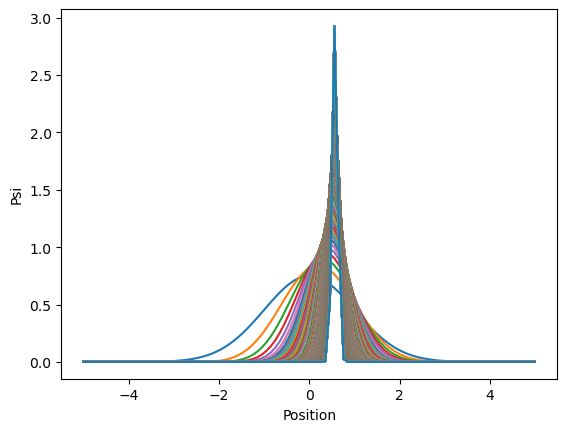

In [29]:
# Plot Psi

plt.figure()
for i in range(0,len(psi_array)):
    plt.plot(grid, psi_array[i], label=i)
plt.xlabel("Position")
plt.ylabel("Psi")
#plt.legend()
plt.show()


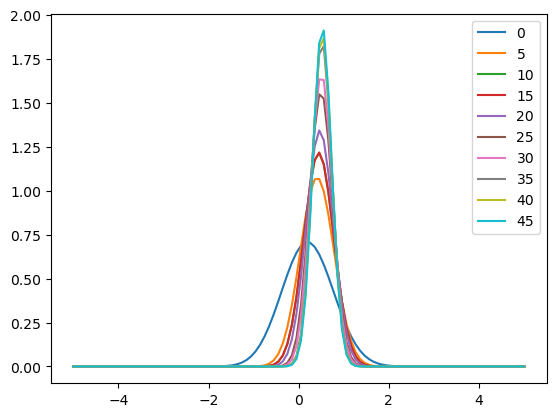

In [41]:
# Plot psi^2 (number density)
iterations=1000
plt.figure()
for i in range(50):
    if i % 5 == 0:
        plt.plot(grid,psi_sq_array[i], label=i)
plt.legend()
plt.show()
#plt.legend()

In [35]:
for i in range(100):
    if i%10==0:
        print(i)

0
10
20
30
40
50
60
70
80
90


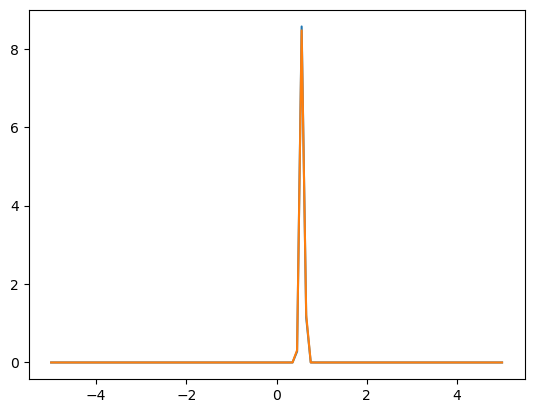

In [ ]:
0,100# Plot psi^2 (number density)

plt.figure()
plt.plot(grid, np.real(psi_sq_array[-1]), label="low temp")
plt.plot(grid,np.real(psi_sq_array2[-1]), label="high temp")
#plt.legend()
plt.show()